#### code to derive cloud fraction with diurnal cycle removed and store it as ncdf. Then, is also calculates mean cloud fraction for SST bins and also saves this data as ncdf in a specific folder.
#### author: Claudia Acquistapace
#### date: 09/12/2021
####  goal: 

- it reads the daily wband radar file, extracts reflectivity, and derives cloud fraction for the day <br>
- it reads the cloud fraction diurnal cycle file <br>
- it then interpolates cloud fraction diurnal cycle on the time resolution of the cloud fraction of the day<br>
- it subtracts and saves the variable without the diurnal cycle for that day<br>
the steps are done for each of the two days. Files are saved for each day <br>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime,timedelta
import matplotlib.dates as mdates
import glob
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
def f_closest(array,value):
    '''
    # closest function
    #---------------------------------------------------------------------------------
    # date :  16.10.2017
    # author: Claudia Acquistapace
    # goal: return the index of the element of the input array that in closest to the value provided to the function
    '''
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    return idx  



# output paths for plots and data files
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
path_out ='/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'

dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :10,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}




# plots settings to be used
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']


In [2]:
# reading data containing flags to filter out rainy columns
flag_file_list = np.sort(glob.glob('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/*_flags_cloud_properties.nc'))
flag_file_list = flag_file_list[13:15]
flag_file_list

array(['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200202_flags_cloud_properties.nc',
       '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200203_flags_cloud_properties.nc'],
      dtype='<U114')

In [3]:
# reading SST data from TSG
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"
# reading tsg file ( data with 1 min resolution)
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

In [4]:
file_list = np.sort(glob.glob("/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/*.nc"))
file_cold_patch = file_list[14:16]
print(file_cold_patch)

['/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/20200202_wband_radar_msm_eurec4a_intake.nc'
 '/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/20200203_wband_radar_msm_eurec4a_intake.nc']


In [5]:

radar_data = xr.open_mfdataset(file_cold_patch)
time = pd.to_datetime(radar_data.time.values)
height = radar_data.height.values
ze = radar_data.radar_reflectivity.values

# convert in a xarray dataset
# defining a xarray dataset for ze
dims             = ['time','height']
coords           = {"time":time, "height":height}

ze_data           = xr.DataArray(dims=dims, coords=coords, data=ze,
                         attrs={'long_name':'radar reflectivity ',
                                'units':''})



variables         = {'ze':ze_data}
global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                    'CREATED_ON'       :  str(datetime.now()),
                    'FILL_VALUE'       :  'NaN', 
                    'PI_NAME'          : 'Claudia Acquistapace',
                    'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                    'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                    'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                    'DATA_DESCRIPTION' : 'Ze in linear units for calculating cloud fraction diurnal cycle',
                    'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                    'DATA_GROUP'       : 'Experimental;Profile;Moving',
                    'DATA_SOURCE'      : 'w band data',
                    'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                    'INSTRUMENT_MODEL' : 'w-band radar',
                     'COMMENT'         : 'original data postprocessed by Claudia Acquistapace' }
dataset_ze    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)

# adding a mask to the ze dataset
dataset_ze["ze_mask"] = xr.full_like(dataset_ze.ze, fill_value=np.nan)

dataset_ze["ze_mask"].values[~np.isnan(ze)] = 1

   

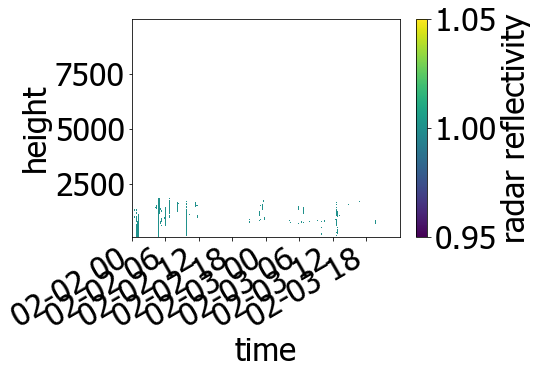

In [6]:
dataset_ze.ze_mask.plot(x='time', y='height')

/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_11461/1401774760.py:29: RuntimeWarning: invalid value encountered in true_divide
  cloud_fraction[ind_time,:] = np.nansum(slice_ze.ze_mask.values, axis=0)/len(slice_ze.time.values)


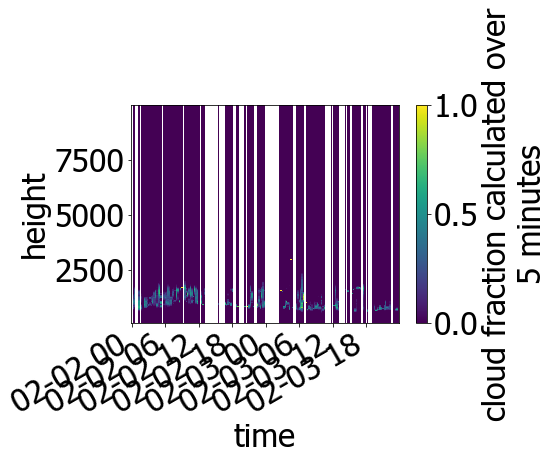

In [7]:
 
# filtering rainy columns from the data
flag_data = xr.open_mfdataset(flag_file_list)
flag_data_interp = flag_data.interp(time=dataset_ze['time'].values, method='nearest')

# selecting time stamps without rain
ind_no_rain = np.where((flag_data_interp["flag_rain_ground"].values == 0) & \
                         (flag_data_interp["flag_rain"].values == 0))[0]
    
# filtering rainy columns 
dataset_no_rain = dataset_ze.sel(time=time[ind_no_rain])
    
# generating time array of 5 min time resolution 
time_start = time[0]
time_end = time[-1]
time_cf = pd.date_range(start=time_start, end=time_end, freq='15min')

# calculating cloud fraction
cloud_fraction = np.zeros((len(time_cf), len(height)))
for ind_time in range(len(time_cf)-1):

    # calculate time extremes
    time_start = time_cf[ind_time]
    time_end = time_cf[ind_time+1]

    # selecting the data
    slice_ze = dataset_no_rain.sel(time=slice(time_start,time_end))

    # calculating cloud fraction as the sum of the ze different than nan divided by the number of time stamps in the interval
    cloud_fraction[ind_time,:] = np.nansum(slice_ze.ze_mask.values, axis=0)/len(slice_ze.time.values)



# saving cloud fraction as xarray dataset
dims             = ['time','height']
coords           = {"time":time_cf, "height":height}
cf_data           = xr.DataArray(dims=dims, coords=coords, data=cloud_fraction,
                         attrs={'long_name':'cloud fraction calculated over 5 minutes',
                                'units':''})  
variables         = {'cf':cf_data}
cloud_fraction_day = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)
cloud_fraction_day.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/cloud_fraction.nc')
cloud_fraction_day.cf.plot(x='time', y='height')

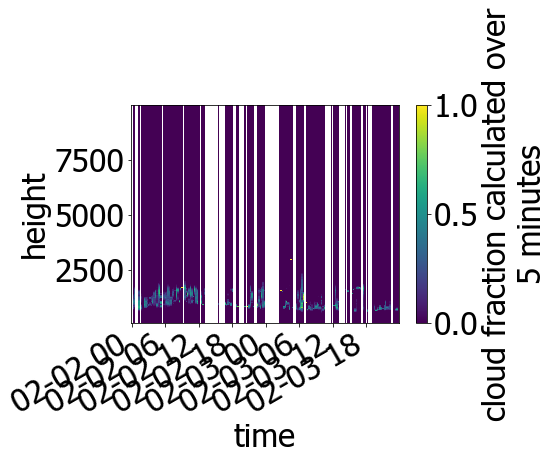

In [11]:

def f_interpolate_SST_and_merge(SST_DS, dataset_obs):
    '''function to interpolate SST values on the time resolution of the observations given as input
    input: 
    SST_DS: xarray dataset containing sst values
    dataset_obs: xarray dataset containing the observations to merge with sst data
    output: 
    data_merged: data returned 
    '''
    
    # interpolating sst data at 1 min resolution to the 10 s res of the wind lidar
    sst_data_interp = SST_DS.interp(time=dataset_obs['time'].values)

    # merging the interpolated dataset and the wind lidar dataset
    data_merged = xr.merge([dataset_obs, sst_data_interp])
    return(data_merged)

# interpolating SST data on the arthus data 
cf_all_SST = f_interpolate_SST_and_merge(SST_DS, cloud_fraction_day)

cf_all_SST.cf.plot(x='time', y='height')


In [13]:
cf_all_SST

<xarray.Dataset>
Dimensions:  (height: 550, time: 192)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-02T00:00:01 ... 2020-02-03T23:45:01
  * height   (height) float32 104.3517 111.8054 119.25909 ... 9948.572 9982.643
Data variables:
    cf       (time, height) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    SST      (time) float64 nan 27.66 27.65 27.67 ... 26.87 26.85 26.86 27.01

In [31]:
# now derives the cloud fraction mean profiles for each SST bin
# building SST binned array
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr = np.arange(SST_min, SST_max, step=0.07)


# calculate label marks for bins
sst_bin_label = []
for ind in range(len(SST_binned_arr)-1):
    sst_bin_label.append(round((SST_binned_arr[ind]+SST_binned_arr[ind+1])/2,2))
print(len(SST_binned_arr))

20


In [32]:

# calculating mean quantities for each bin
dataset_mean = []
dataset_std = []

# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = cf_all_SST.where((cf_all_SST.SST > SST_binned_arr[ind_bin]) & (cf_all_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)


    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    print(n_el)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
    dataset_std.append(DS_sliced.std(dim='time', skipna=True))

# concatenating datasets corresponding to SST bins on a new bin dimension
cf_SST_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
cf_SST_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')



cf_SST_concat

6
8
14
10
8
7
9
11
15
15
14
13
9
6
5
12
6
3
10


<xarray.Dataset>
Dimensions:     (SST_binned: 19, height: 550)
Coordinates:
  * height      (height) float32 104.3517 111.8054 ... 9948.572 9982.643
Dimensions without coordinates: SST_binned
Data variables:
    cf          (SST_binned, height) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SST         (SST_binned) float64 26.32 26.4 26.46 ... 27.42 27.51 27.59
    n_elements  (SST_binned) float64 6.0 8.0 14.0 10.0 8.0 ... 12.0 6.0 3.0 10.0

In [33]:


# saving variable of interest in a dictionary with its name
dims             = ['sst','height']
coords           = {'sst':cf_SST_concat.SST.values, 'height':cf_SST_concat['height'].values}
cf_datarray = xr.DataArray(dims=dims, coords=coords, data=cf_SST_concat['cf'].values,
                             attrs={'long_name':'mean cloud fraction binned over SST',
                                    'units':''})
variables = {'cf':cf_datarray}

global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : 'cloud fraction with the diurnal cycle removed from the data',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Wband radar',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'Wband radar data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'Wband radar system',
                         'COMMENT'         : 'original data postprocessed by Claudia Acquistapace' }
dataset_out    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)
dataset_out.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/cloud_fraction_binned_sst.nc')



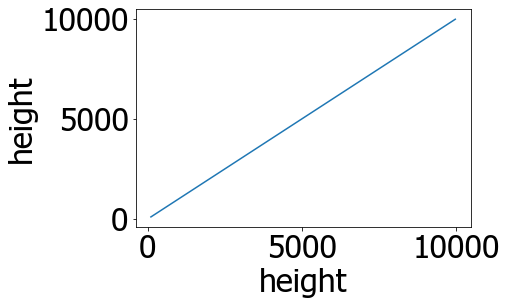

In [34]:
dataset_out.height.plot()

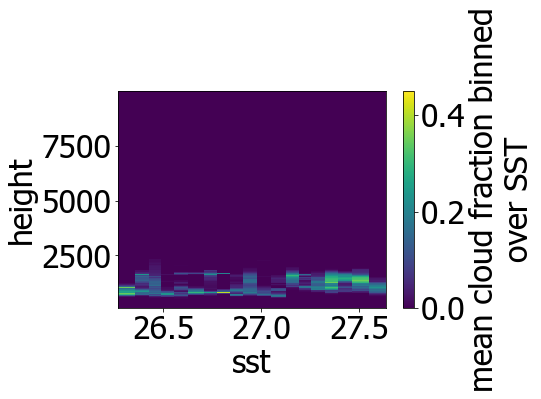

In [35]:
dataset_out.cf.plot(x='sst', y='height')

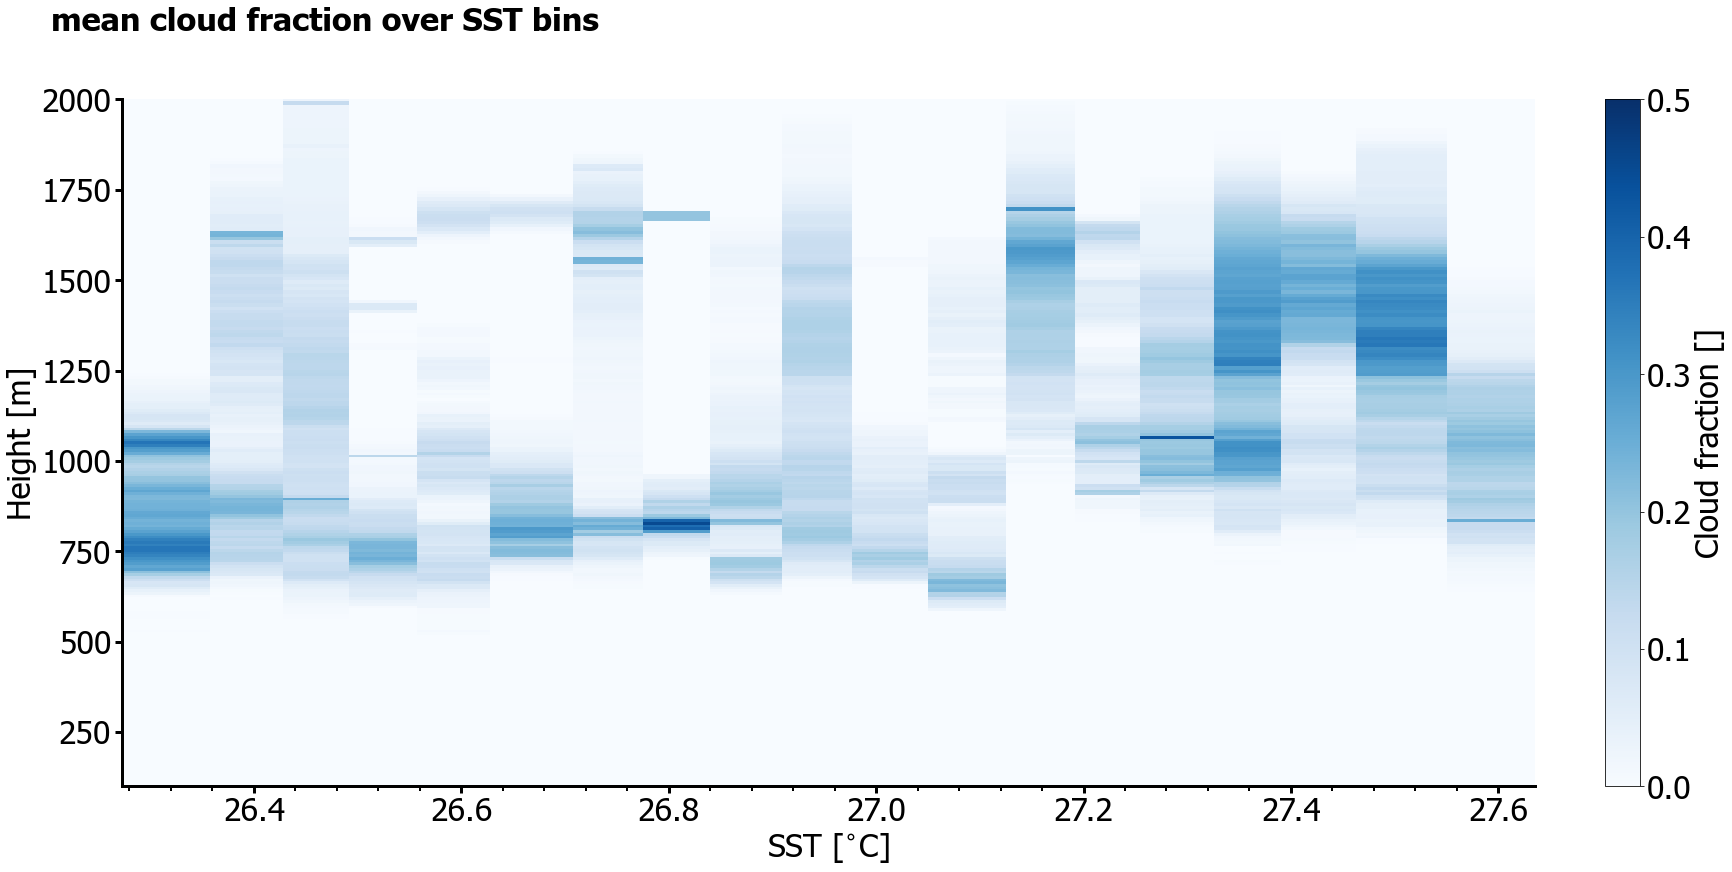

In [41]:
# plot 
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']
fig, axs = plt.subplots( figsize=(24,12), constrained_layout=True)

# setting dates formatter 
#[a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) for a in axs[:].flatten()]
matplotlib.rc('xtick', labelsize=32)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=32)  # sets dimension of ticks in the plots
grid            = dict_plot_settings['grid']

mesh = axs.pcolormesh(dataset_out.sst.values, dataset_out.height.values, dataset_out.cf.values.T, cmap='Blues', vmin=0., vmax=.5, )
cbar = fig.colorbar(mesh, ax=axs)
cbar.set_label(label='Cloud fraction []',  size=fontSizeX)
axs.set_ylabel('Height [m]', fontsize=fontSizeX)
axs.set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

axs.text(-0.05, 1.1, 'mean cloud fraction over SST bins',  fontweight='black', fontsize=fontSizeX, transform=axs.transAxes)
#ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)

axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["bottom"].set_linewidth(3)
axs.spines["left"].set_linewidth(3)
axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs.tick_params(which='minor', length=5, width=2)
axs.tick_params(which='major', length=7, width=3)
axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs.tick_params(axis='both', labelsize=32)
axs.set_ylim(100.,2000.)

fig.savefig(path_out_plots+'figure_cf_binned.png', format='png')


In [ ]:
NO IMPORTANCE
   
    # plots settings to be used
    rcParams['font.sans-serif'] = ['Tahoma']
    matplotlib.rcParams['savefig.dpi'] = 100
    plt.rcParams.update({'font.size':22})
    grid = True
    fig2, axs = plt.subplots(3,1, figsize=(16,10), constrained_layout=True, sharex=True)
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["bottom"].set_linewidth(3)
    axs[0].spines["left"].set_linewidth(3)
    grid=True
    mesh1 = axs[0].pcolormesh(d_cycle['time'].values, d_cycle['height'].values, \
                                 d_cycle['cloud_fraction'].values.T, vmin=0., \
                             vmax=0.01, cmap='Blues', rasterized=True)
    cbar = fig2.colorbar(mesh1, ax=axs[0], label='cloud fraction diurnal cycle', \
                            location='right', aspect=20, use_gridspec=grid)


    axs[0].set_ylabel('Height [m]')
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[0].text(0, 1.02, 'Diurnal cycle of cloud fraction', \
                fontweight='black', transform=axs[0].transAxes)
    axs[0].set_ylim(200., 3500.)

    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["bottom"].set_linewidth(3)
    axs[1].spines["left"].set_linewidth(3)
    mesh1 = axs[1].pcolormesh(cloud_fraction_day['time'].values, cloud_fraction_day['height'].values, \
                                 var_no_dc.T, cmap='seismic', vmin=-10., vmax=10., rasterized=True)
    cbar = fig2.colorbar(mesh1, ax=axs[1], label='$\Delta$ cloud fraction ', \
                            location='right', aspect=20, use_gridspec=grid)


    axs[1].set_ylabel('Height [m]')
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[1].text(0, 1.02, 'Time serie of cloud fraction without diurnal cycle -'+date, \
                fontweight='black', transform=axs[1].transAxes)
    axs[1].set_ylim(200., 3500.)

    axs[2].spines["top"].set_visible(False)
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["bottom"].set_linewidth(3)
    axs[2].spines["left"].set_linewidth(3)
    axs[2].plot(pd.to_datetime(SST_DS['time'].values), SST_DS['SST'].values)
    axs[2].set_ylim(26., 28.)
    axs[2].set_xlabel('Time UTC [HH:MM]')
    axs[2].set_ylabel('SST [$^{\circ}$C]')
    axs[2].set_xlim(time_start, time_end)
    fig2.savefig(path_out_plots+'cloud_fraction_'+date+'_overview_anomaly_dc.png')

    # saving variables without diurnal cycle in a ncdf file
    # save xarray dataset containing the correction terms for the hour
    dims             = ['time','height']
    coords           = {"time":cloud_fraction_day['time'].values, "height":cloud_fraction_day['height'].values}

    var_nodc          = xr.DataArray(dims=dims, coords=coords, data=var_no_dc,
                             attrs={'long_name':'cloud fraction without diurnal cycle',
                                    'units':''})

    variables         = {'cloud_fraction_no_dc':var_nodc}
    global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : 'cloud fraction with the diurnal cycle removed from the data',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing wband radar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : ' wband radar data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : ' wband radar',
                         'COMMENT'         : 'original data postprocessed by Claudia Acquistapace' }
    dataset    = xr.Dataset(data_vars = variables,
                                      coords = coords,
                                       attrs = global_attributes)
    dataset.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'+date+'cloud_fraction_no_dc.nc')

